In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy as sy
import scipy.stats
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy import ndimage
import PIL.Image
import math
import os
import string

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)


from statistical_analysis import correlate
from statistical_analysis import comparison_distributions
from math_tools import lin_fit
from math_tools import line
from plotting_tools import set_layout
from plotting_tools import save_figures
from matrix_analysis import Select_entangled_fraction
from matrix_analysis import length_L_pattern

In [2]:
def read_topology_matrix(file):
    
    #open file
    if file.endswith('.feather'):
        df = pd.read_feather(file)
    elif file.endswith('.csv'):
        df = pd.read_csv(file)
        
        
    size = df['Index1'].max() + 1


    #compose matrix and fill in 2D array
    new_matrix = np.ones((size, size))
    
    for row in df.iterrows():
        x = int(row[1]['Index1'])
        y = int(row[1]['Index2'])
        value = row[1]['Values']
        new_matrix[x, y] = value
    
        if value == 3.:
            new_matrix[y, x] = 2.
        elif value == 5.:
            new_matrix[y, x] = 6.
    
        elif value == 6.:
            new_matrix[y, x] = 5.
        else:
            new_matrix[y, x] = value
    
    return new_matrix

def CreateDf_SegmentComparison(dataframe, method):
    df_plot={'Sample':dataframe['Sample'], 'Chr ID':dataframe['Chr ID'], 'Selection':dataframe[method]}
    df_plot=pd.DataFrame(data=df_plot)
    return df_plot

def Plot_SegmentComparison(df_segment_comparison, segments, clustering = None):
    cell = df_segment_comparison.columns[0]
    chrID= df_segment_comparison.columns[1]
    selection = df_segment_comparison.columns[2]
    df_segment_comparison=df_segment_comparison.pivot(cell, chrID, selection)
    
    #Reorder chromosomes
    columns =  df_segment_comparison.columns
    cols = list(columns[0]) + list(columns[11])+ list(columns[-8:-1])+list(columns[1:11]) + list(columns[12:15]) + list(columns[-1])
    df_segment_comparison = df_segment_comparison[cols]
    
    g = plt.figure(figsize = (10, 2.7))
    cmap = sns.color_palette("icefire", as_cmap=True)
    ax= sns.heatmap(df_segment_comparison, cbar_kws={'label': 'Segment'}, cmap = cmap)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(segments)
    
    if clustering:
        plt.title('L loops local {}, {}'.format(method[-6:].lower(), clustering))
    else:
        plt.title('L loops local {}'.format(method[-6:].lower()))
        
    plt.tight_layout()
    return g, columns


In [3]:
resolution = '40'
thresh = 0.99
n_segments=4
path_matrices = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']

chromosomes = [str(t) for t in range(1,23)]
chromosomes.append('X')


Read matrices and make L pattern dataframe

In [4]:

df_tot=pd.DataFrame()


for sample in samples:
    print(sample)
    df = pd.DataFrame()
    

    n_contacts = []
    length_tot = []
    mean = []
    sum_loops = []
    Chr_ID = []
    segment = []
    
    for chrom in chromosomes:
        print(chrom)
        for t in range(n_segments):
            
            try:
                matrix = read_topology_matrix(f'{path_matrices}/{chrom}_{sample}_{t}.feather')
                imarray = Select_entangled_fraction(np.copy(matrix))
                length=length_L_pattern(imarray)
                size=imarray.shape[0]
            
                length=length[length!=0.]
            
                if (len(length) == 0):
                    print('ERROR WARNING: Empty length')
                    length_tot.append(0)
                    mean.append(0)
                    sum_loops.append(0)
                    n_contacts.append(0)
                
                else:
                  
                    length_tot.append(length) 
                    mean.append(np.mean(length))
                    sum_loops.append(np.sum(length))
                    n_contacts.append(size)
                    
            except:
                print('ERROR WARNING: Empty matrix')
                length_tot.append(0)
                mean.append(0)
                sum_loops.append(0)
                n_contacts.append(0)
            
            segment.append(t)
            Chr_ID.append(chrom)
            
    length_tot=tuple(length_tot)  
    mean = tuple(mean)
    df['length']=pd.Series(length_tot)  
    df['n contacts']= pd.Series(n_contacts)
    df['Mean'] = pd.Series(mean)
    df['Sum'] = pd.Series(sum_loops)
    
    df['Chr ID']=pd.Series(Chr_ID)
    df['Segment']=pd.Series(segment)
    df['Sample'] = pd.Series([sample]* len(df))
    
    frames = [df_tot, df]
    df_tot = pd.concat(frames)


Control1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Control2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Treated1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Treated2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X


In [6]:
path_results = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments/dataframe'
df_tot.to_csv(f'{path_results}/Segments.csv')

In [7]:
path_figure = f'results counts/figures/{resolution}/segments'

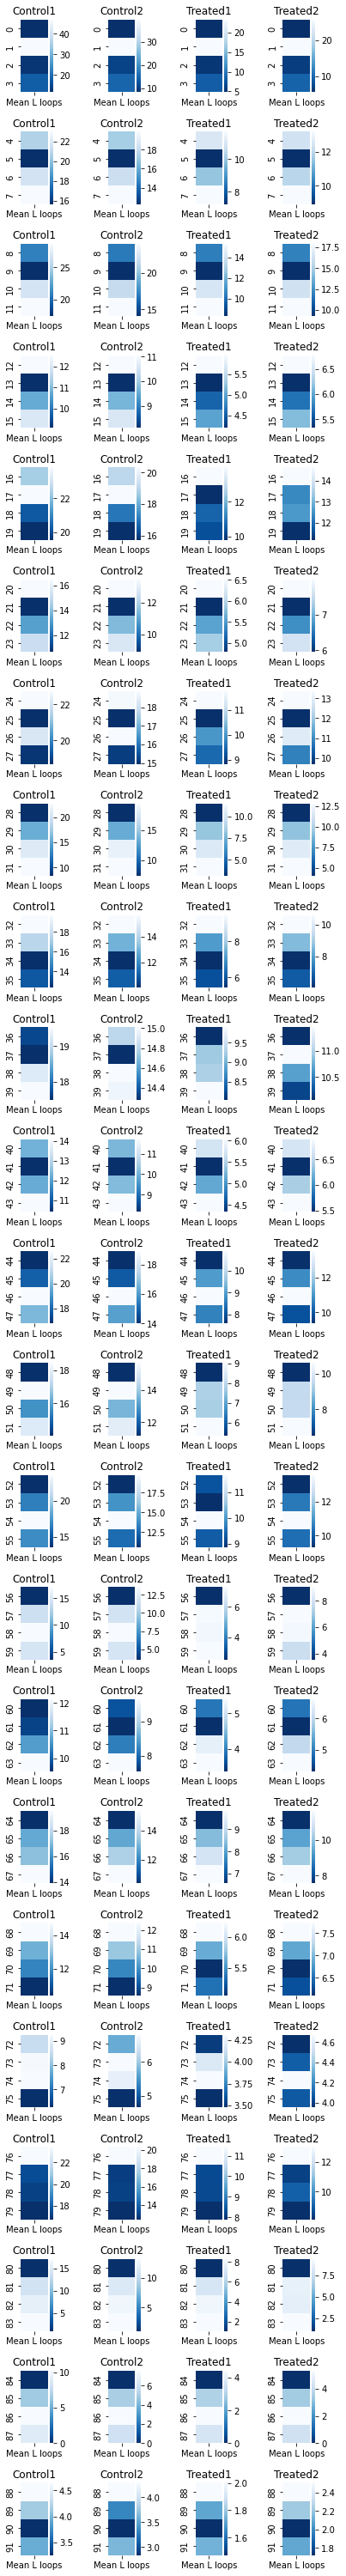

In [8]:
width_figure=6
length_figure=42
fig, ax = plt.subplots(nrows= len(chromosomes), ncols=len(samples),figsize=(width_figure,length_figure))
fig.tight_layout(pad=2.5)
plot_quantity =  'Mean'


for i, sample in enumerate(samples):
    for j, chrom in enumerate(chromosomes):
        df_plot=df_tot[(df_tot['Sample']==sample) & (df_tot['Chr ID'] == chrom)]
        
        map_chr=df_plot[plot_quantity]
        df_seg={f'{plot_quantity} L loops': map_chr}
        df_seg=pd.DataFrame(data=df_seg)
    
        #i,j=np.unravel_index(t,(5,4))
        ax[j, i].set_title('{}'.format(sample))
        sns.heatmap(df_seg, cmap='Blues_r', ax = ax[j,i])  #vmin=0, vmax=df_tot[plot_quantity].max())
        #plt.tight_layout()
    
save_figures(fig, path = path_figure, name_file = f'segments_{n_segments}_{thresh}', method= plot_quantity)


## SEGMENT ANALYSIS

Load the dataset you want to analyse (pick resolution and number of segments)

In [9]:
resolution = 40
n_segments = 4
path_figure = f'results counts/figures/{resolution}/segments'
path_data = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments/dataframe'
data = pd.read_csv(f'{path_data}/Segments.csv')
data

,Unnamed: 0,length,n contacts,Mean,Sum,Chr ID,Segment,Sample
0,0,[1. 4. 2. ... 3. 1. 1.],6989,11.708100,81664.0,1,0,Control1
1,1,[2. 2. 6. ... 3. 1. 1.],9179,46.821214,429491.0,1,1,Control1
2,2,[4. 4. 9. ... 3. 1. 1.],4736,12.617093,59641.0,1,2,Control1
3,3,[2. 2. 4. ... 3. 1. 1.],8244,17.961884,147970.0,1,3,Control1
4,4,[4. 4. 7. ... 3. 1. 1.],9473,20.707559,196142.0,2,0,Control1
...,...,...,...,...,...,...,...,...
363,87,[ 2. 2. 3. 1. 1. 4. 4. 7. 9. 9. 3. ...,931,4.249727,3897.0,22,3,Treated2
364,88,[1. 1. 1. ... 3. 1. 1.],2190,2.507253,5358.0,X,0,Treated2
365,89,[1. 1. 2. ... 1. 1. 1.],1673,2.212780,3359.0,X,1,Treated2
366,90,[1. 1. 1. ... 1. 1. 1.],1832,1.719745,2970.0,X,2,Treated2


We want to see the differences in local distribution between control and treated samples. But, we have two control and two treated samples, so we will average them to have only one control and one sample signal

In [10]:
df_control1 = data[data['Sample'] == 'Control1']
df_control2 = data[data['Sample'] == 'Control2']

df_treated1 =  data[data['Sample'] == 'Treated1']
df_treated2 =  data[data['Sample'] == 'Treated2']

In [11]:
mean_control = (np.array(df_control2['Mean']) + np.array(df_control1['Mean']))/2
sum_control = (np.array(df_control2['Sum']) + np.array(df_control1['Sum']))/2

df_control = {'Mean': mean_control, 'Sum': sum_control, 'Chr ID': df_control2['Chr ID'], 'Segment': df_control2['Segment'],
              'Sample': ['Control']*len(df_control2)}
df_control = pd.DataFrame(df_control)

In [12]:
mean_treated = (np.array(df_treated1['Mean']) + np.array(df_treated2['Mean']))/2
sum_treated = (np.array(df_treated1['Sum']) + np.array(df_treated2['Sum']))/2

df_treated = {'Mean': mean_treated, 'Sum': sum_treated, 'Chr ID': df_treated2['Chr ID'], 'Segment': df_treated2['Segment'],
              'Sample': ['Treated']*len(df_treated2)}
df_treated = pd.DataFrame(df_treated)

In [13]:
frames = [df_control, df_treated]
all_data = pd.concat(frames)

<AxesSubplot:xlabel='Sample', ylabel='Mean'>

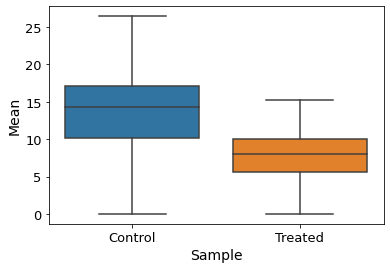

In [14]:
set_layout()
sns.boxplot(y = 'Mean', x = 'Sample', data = all_data, showfliers = False)

In [15]:
all_data

,Mean,Sum,Chr ID,Segment,Sample
92,10.083484,65921.0,1,0,Control
93,43.182627,382432.0,1,1,Control
94,11.677113,53082.5,1,2,Control
95,16.394892,130160.5,1,3,Control
96,18.972105,172800.5,2,0,Control
...,...,...,...,...,...
363,3.957430,3541.0,22,3,Treated
364,2.254170,4519.0,X,0,Treated
365,1.964383,2688.5,X,1,Treated
366,1.594786,2508.0,X,2,Treated


In [16]:
n_chromosomes = len(chromosomes)

In [17]:
samples = ['Control', 'Treated']
len_index=n_chromosomes*len(samples)
min_array=np.zeros(len_index, dtype = int)
max_array=np.zeros(len_index, dtype = int)
chrom_array=['']*len_index
sample_array=['']*len_index
min_array_sum= np.zeros(len_index, dtype = int)
max_array_sum= np.zeros(len_index, dtype = int)
#max_label_array= np.zeros(len_index)


index=0
for sample in samples:
    for chrom in chromosomes:
        df_chr=all_data[(all_data['Chr ID']== chrom) & (all_data['Sample']== sample)]
        
        #MEAN

        max_mean=df_chr['Mean'].max()
        max_pos=df_chr['Segment'][df_chr['Mean']==max_mean]
        
        min_mean=df_chr['Mean'].min()
        min_pos=df_chr['Segment'][df_chr['Mean']==min_mean]
        min_array[index]=int(min_pos.array[0])+1
        max_array[index]=int(max_pos.array[0])+1
        chrom_array[index]= chrom
        sample_array[index]= sample
        
        #SUM
        
        max_sum=df_chr['Sum'].max()
        max_pos=df_chr['Segment'][df_chr['Sum']==max_sum]
        min_sum=df_chr['Sum'].min()
        min_pos=df_chr['Segment'][df_chr['Sum']==min_sum]
        min_array_sum[index]=int(min_pos.array[0])+1
        max_array_sum[index]=int(max_pos.array[0])+1
              
        index=index+1         

#Store data in dataframe
df_comparison={'Chr ID': chrom_array, 'Sample': sample_array, 'Mean Minima': min_array, 'Mean Maxima': max_array, 
              'Sum Minima':min_array_sum, 'Sum Maxima':max_array_sum}

df_comp=pd.DataFrame(data=df_comparison)

In [18]:
df_comp

,Chr ID,Sample,Mean Minima,Mean Maxima,Sum Minima,Sum Maxima
0,1,Control,1,2,3,2
1,2,Control,2,4,2,4
2,3,Control,2,4,2,4
3,4,Control,2,1,2,1
4,5,Control,4,2,4,1
5,6,Control,2,1,2,4
6,7,Control,2,1,2,1
7,8,Control,1,4,1,4
8,9,Control,3,1,2,1
9,10,Control,2,4,2,4


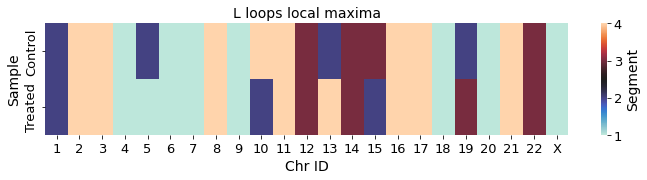

In [20]:
set_layout()
dataframe = df_comp
method = 'Mean Maxima'
name_file=f'L loops comparison {n_segments}'

df_heatmap=CreateDf_SegmentComparison(df_comp, method = method)
plot, col= Plot_SegmentComparison(df_heatmap, segments = np.arange(1, n_segments+1, 1))
save_figures(plot, path_figure, name_file, method)

In [21]:
col

Index(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X'],
      dtype='object', name='Chr ID')

In [22]:
mean_shift = np.array(df_control['Mean']) - np.array(df_treated['Mean'])
sum_shift = np.array(df_control['Sum']) - np.array(df_treated['Sum'])

df_shift = {'Delta Mean': mean_shift, 'Delta Sum': sum_shift, 'Chr ID': df_control['Chr ID'], 'Segment': df_control['Segment']}
df_shift = pd.DataFrame(df_shift)
df_shift

,Delta Mean,Delta Sum,Chr ID,Segment
92,4.892786,41047.5,1,0
93,18.637230,200147.5,1,1
94,5.705626,32652.5,1,2
95,7.606889,75952.5,1,3
96,7.280079,85876.5,2,0
...,...,...,...,...
179,3.529471,5804.0,22,3
180,2.216133,7369.5,X,0
181,1.764415,4714.0,X,1
182,1.448072,3846.0,X,2


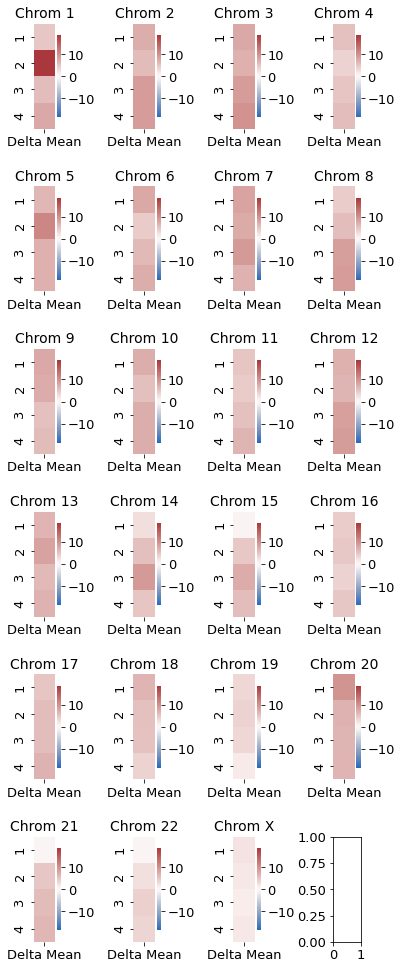

In [24]:
width_figure=6
length_figure=14

plot_quantity = 'Delta Mean'
fig, ax = plt.subplots(nrows= 6, ncols= 4,figsize=(width_figure,length_figure))
fig.tight_layout(pad=2.5)

for t, chrom in enumerate(chromosomes):
    df_plot=df_shift[df_shift['Chr ID'] == chrom]
        
    map_chr=df_plot[plot_quantity]
    df_seg={f'{plot_quantity}': map_chr}
    df_seg=pd.DataFrame(data=df_seg)
    ylabels = np.arange(1,n_segments + 1, 1)
    
    i,j=np.unravel_index(t,(6,4))
    ax[i, j].set_title(f'Chrom {chrom}')
    cmap = sns.color_palette("vlag", as_cmap=True)
    #plt.figure()
    sns.heatmap(df_seg, cmap= cmap, vmin =  -df_shift[plot_quantity].max(), vmax = df_shift[plot_quantity].max(),
                yticklabels= ylabels, ax = ax[i,j])
    
save_figures(fig, path_figure, name_file = f'barcode_{n_segments}', method = plot_quantity)

In [247]:
df_shift[plot_quantity].min()

-0.2857142857142856

In [248]:
df_shift[plot_quantity].max()

10.289343001403813